## Methods

### 1. Image Pre-processing

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


# 2. Download data set
file_ds = drive.CreateFile({'id': '1jLWrWF2VYnJT1tWSyhpVR3l40_IdpCxl'})
file_ds.GetContentFile('breast_data.zip')

# !rm -rf dataset-master
!rm -rf breast_data  

# !unzip -q dataset.zip
!unzip -q breast_data.zip

# ! make a directory BreaKHis
!mkdir BreaKHis

# Put all the images to BreaKHis
!mv 0/* BreaKHis/
!mv 1/* BreaKHis/

# Delete unused files
!rm -rf 0
!rm -rf 1
!rm -rf __MACOSX/
!rm -rf adc.json

In [0]:
# Mount the google drive to save the intermediate outputs
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
# Import libraries for image pre-processing
import os, time
import cv2
import numpy as np
from multiprocessing import Pool
from tqdm import tqdm
from typing import List, Text, Dict
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


In [0]:
# Setting the directory of train and test datasets
IMAGE_DIR = "BreaKHis"
IMAGE_PROCESSED = "/gdrive/My Drive/Colab Notebooks/Medical informatics/Project/data/BreaKHis_processed"

def dic_patient_directory(directory: Text, ext) -> Dict:
    result = {}
    for root, _, files in os.walk(directory):
        for f in files:
            if f.endswith(ext):
                patient = f.split('-')[2]
                if patient in result:
                    result[patient].append(os.path.join(root, f))
                else:
                    result[patient] = [os.path.join(root, f)]
    return result

def list_pictures(directory: Text, magnification_factor, ext) -> List:
    # return a list contains paths of all histopathologic images of given size 
    return [os.path.join(root, f)
            for root, _, files in os.walk(directory) for f in files
            if f.endswith(ext)
            if f.split('-')[3] == magnification_factor]

def gaussian_blur(image):
    return cv2.GaussianBlur(image, (3, 3), cv2.BORDER_DEFAULT)

def rgb_to_hsv(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # define range of blue color in HSV
    #lower_blue = np.array([110,50,50])
    #upper_blue = np.array([130,255,255])
    # Threshold the HSV image to get only blue colors
    #mask = cv2.inRange(hsv, lower_blue, upper_blue)
    # Bitwise-AND mask and original image
    #res = cv2.bitwise_and(image, image, mask= mask)
    return hsv

def img_augmentation(img, save_dir=None, name=None, num_generate=2) -> List:
    """using keras default data generator to for data augmentation
    """
    # the generae paramerters
    datagen = ImageDataGenerator(
             rotation_range=0.2,
             width_shift_range=0.2,
             height_shift_range=0.2,
             shear_range=0.2,
             zoom_range=0.2,
             horizontal_flip=True,)
    
    #img = load_img(image_dir) 
    #img = img_to_array(img)  # this is a Numpy array with shape (3, width, height)
    # this is a Numpy array with shape (1, 3, width, height):tensorflow backen
    img = img.reshape((1,) + img.shape)  
     
    # the .flow() command below generates batches of randomly transformed images 
    num = 0
    gen_list = []
    for img_gen in datagen.flow(img,
                               batch_size = 1,
                               #save_to_dir = save_dir, # the path for saving
                               #save_prefix = 'keras_gen' + name,
                               #save_format = 'png'
                               ):
        gen_list.append(img_gen)
        num += 1
        if num > num_generate: # how many data to generate
            break
    return gen_list

def cutout_augmentation(img, save_dir=None, name=None, size_range=0.85, stride=20, image_index=0, num_generate=2):
    """generate new images by cutting out some random parts of the original images
       Args:
            size_range:mask_size / original_image_size
            stride:how many pixels the cutting mask move at each step
    """
    image = cv2.imread(image_dir)
    height, width, N = image.shape
    shortest_edge = min(height, width)
    img_size = int(shortest_edge * size_range)
    num_cut = int(shortest_edge * (1-size_range) / stride)
    
    num = 0
    gen_list = []
    for num in num_generate:
        for num_height in range(num_cut):   # generate a mask to sample the image by cutting  
            for num_width in range(num_cut):  
                x = stride * num_height
                y = stride * num_width
                image_cut = image[y : y + img_size, x : x + img_size]
                # saving the images
                #fname = '{index}_{hash}_{type}_{name}.{format}'.format(index=image_index,
                #                                                       hash=np.random.randint(1e4),
                #                                                       type='cutout_gen',
                #                                                       name=name,
                #                                                       format='png')
                #write_dir = save_dir + fname
                #cv2.imwrite(write_dir, image_cut)
                gen_list.append(image_cut)
    return gen_list

    
def preprocessing(image_dirs, target_dir, magnification_factor, extension):
    for image_dir in tqdm(list_pictures(image_dirs, magnification_factor, extension)):
        image = cv2.imread(image_dir)
        image = gaussian_blur(image)  #460*700*3
        # transfer the image from rgb to gray for histogram equlization
        # gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # equ = cv2.equalizeHist(gray)  #460*700
        # equ = np.expand_dims(equ, axis=2)  #460*700*1
        # transfer the image from rgb to hsv
        hsv = rgb_to_hsv(image)   #460*700*3
        # save the pre-processed image
        directory, file_name = os.path.split(image_dir)
        # sub_directory = directory.split(os.sep)[4]
        if not os.path.exists(target_dir):
            os.makedirs(target_dir)
        #cv2.imwrite(os.path.join(target_dir, file_name), image)
        #cv2.imwrite(os.path.join(target_dir, file_name), hsv)
        #cv2.imwrite(os.path.join(target_dir, file_name), equ)
        images_aug = img_augmentation(image)
        hsvs_aug = img_augmentation(hsv)
        for i, (image_aug, hsv_aug) in enumerate(zip(images_aug, hsvs_aug)):
            img_rgb_hsv = np.concatenate((image_aug, hsv_aug), axis=1) # 1*920*700*3
            np.save(os.path.join(target_dir, file_name + '-' + str(i) + '.npy'), img_rgb_hsv)
        #k = cv2.waitKey(1005) & 0xFF
        #if k == 27:
        #    break
    cv2.destroyAllWindows()

In [0]:
if __name__ == '__main__':
    magnification_factors = ['40', '100', '200', '400']
    extension = '.png'
    multi1 = time.time()
    print('Parent process {0}'.format(os.getpid()))
    p = Pool(4)   # create four sub processes
    # create four sub processes
    for i in range(4):
        p.apply_async(preprocessing,
                      args=(os.path.join(IMAGE_DIR),
                            os.path.join(IMAGE_PROCESSED, magnification_factors[i]),
                            magnification_factors[i],
                            extension
                            )
                      )
    print('Waiting for all subprocesses done...')
    p.close()
    p.join()
    print('All subprocesses done.')
    multi2 = time.time()
    print('Time comsumed:', multi2 - multi1)

Parent process 70251


  0%|          | 0/2013 [00:00<?, ?it/s]

Waiting for all subprocesses done...


100%|██████████| 2081/2081 [1:06:57<00:00,  1.76it/s]


All subprocesses done.
Time comsumed: 4018.477473258972


### 2. Feature Extraction

In [0]:
import numpy as np
from multiprocessing import Pool
import cv2
import tensorflow as tf
from keras.models import Model
from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input as xception_preprocess_input
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input as vgg19_preprocess_input
from keras.preprocessing import image
import warnings
warnings.filterwarnings('ignore')
import progressbar
from __future__ import print_function

In [0]:
# Organizing the dataset
IMAGE_PROCESSED = "/gdrive/My Drive/Colab Notebooks/Medical informatics/Project/data/BreaKHis_processed"
magnification_factors = ['40', '100', '200', '400']
model_names = ['xception', 'vgg16', 'vgg19']

In [0]:
# Pre-trained CNN models for feature extraction
model1 = Xception(weights='imagenet', include_top=False) #imports the Xception model and discards the last classification layer.
model2 = VGG16(weights='imagenet', include_top=False) #imports the VGG16 model and discards the last classification layer.
base_model = VGG19(weights='imagenet')
model3 = Model(inputs=base_model.input, outputs=base_model.get_layer('block4_pool').output) #imports the VGG19 model and discards the last classification layer.
models = {'xception': (model1, xception_preprocess_input, (299, 299)),
          'vgg16': (model2, vgg16_preprocess_input, (224, 224)),
          'vgg19': (model3, vgg19_preprocess_input, (224, 224))
          }

In [0]:
# Transform pre-processed data into a numpy array as the input of pre-trained CNN feature extractor
def dir_to_array(input_path, magnification_factor, model_name, input_shape, output_path, verbose=1):
    data = []
    labels = []
    patients = []
    for img_dir in list_pictures(input_path, magnification_factor, ext='.npy'):
        x = np.load(img_dir) #(1, 920, 700, 3)
        x = np.squeeze(x, axis=0) # (920, 700, 3)
        x = cv2.resize(x, dsize=input_shape, interpolation=cv2.INTER_CUBIC) #((input_size), 3)
        data.append(x)
        directory, file_name = os.path.split(img_dir)
        if file_name.split('_')[1] == 'B':
            label = 0
        elif file_name.split('_')[1] == 'M':
            label = 1
        labels.append(label)
        patients.append(file_name.split('-')[2])
    data = np.stack(data, axis=0) #(n, (input_size), 3)
    labels = np.asarray(labels) 
    patients = np.asarray(patients)
    output_path = os.path.join(output_path, model_name, magnification_factor)
    if not os.path.exists(output_path):
      os.makedirs(output_path)
    np.save(os.path.join(output_path, 'data.npy'), data) # data #(n, (input_size), 3)
    np.save(os.path.join(output_path, 'labels.npy'), labels) # labels
    np.save(os.path.join(output_path, 'patients.npy'), patients) # patients

In [0]:
# Get the input for Xception/VGG16/VGG19
def get_the_input(model_name):
  output_path = "/gdrive/My Drive/Colab Notebooks/Medical informatics/Project/data/for feature_extraction"
  # Get the input array for each model
  for i in range(4):
    dir_to_array(IMAGE_PROCESSED, magnification_factors[i], model_name, models[model_name][2], output_path)
  
get_the_input("xception")

In [0]:
get_the_input("vgg16")

In [0]:
get_the_input("vgg19")

In [0]:
# Define a function to extract features using pre-trained network
def feature_extraction(model_name, 
                       magnification_factor,
                       input_path="/gdrive/My Drive/Colab Notebooks/Medical informatics/Project/data/for feature_extraction",
                       out_path="/gdrive/My Drive/Colab Notebooks/Medical informatics/Project/data/features"
                       ):
    input_path = os.path.join(input_path, model_name, magnification_factor)
    #extraction_model = build_extraction_model(model_name)
    data = np.load(os.path.join(input_path, 'data.npy')) # (n, (input_size), 3)
    # The network expects one or more images as input; that means the input array will need to be 4-dimensional:
    # samples, rows, columns, and channels.  channel number of 3 is required for pre-trained model
    X = models[model_name][1](data)
    features = models[model_name][0].predict(X)
    feature_path = os.path.join(out_path, model_name, magnification_factor)
    if not os.path.exists(feature_path):
        os.makedirs(feature_path)
    np.save(os.path.join(feature_path, 'X.npy'), features)

In [0]:
# Extract features using Xception/VGG16/VGG19 respectively
def get_the_features(model_name):
  # Extract features for each image size  
  for i in range(4):
    feature_extraction(model_name, magnification_factors[i])

get_the_features("xception")

In [0]:
get_the_features("vgg16")

In [0]:
get_the_features("vgg19")

### 3.Classification

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import GroupShuffleSplit

# Different Candidate Classification Algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB

# Classification Performance
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [0]:
# Spliting the features into training and testing set at 80%/20% ratio
def train_test_group_split(X, y, p):
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=2)
    for train_index, test_index in gss.split(X, y, p):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        p_train, p_test = p[train_index], p[test_index]
    return X_train, y_train, X_test, y_test, p_train, p_test

# Define a function to Describe Features extracted
def describeData(X,y):
    print('Total number of images: {}'.format(len(X)))
    print('Number of Benign Images: {}'.format(np.sum(y==0)))
    print('Number of Malignant Images: {}'.format(np.sum(y==1)))
    print('Percentage of positive images: {:.2f}%'.format(100*np.mean(y)))
    print('Feature Dimension: {}'.format(X.shape))
    print()

def feature_dimension(model, factor):
    X = np.load('/gdrive/My Drive/Colab Notebooks/Medical informatics/Project/data/features/' + model + '/' + str(factor)+'/X.npy')
    y = np.load('/gdrive/My Drive/Colab Notebooks/Medical informatics/Project/data/for feature_extraction/' + model + '/' + str(factor)+'/labels.npy')
    p = np.load('/gdrive/My Drive/Colab Notebooks/Medical informatics/Project/data/for feature_extraction/' + model + '/' + str(factor)+'/patients.npy')
    print('Discription of features extracted from ' + str(factor) + 'x images by model ' + model + ":")
    X_train, y_train, X_test, y_test, p_train, p_test = train_test_group_split(X, y, p)
    print('Training Set')
    describeData(X_train, y_train)
    print('Testing Set')
    describeData(X_test, y_test)
    print("-----------------------------------------------------------------------")

In [0]:
# Showing the features dimension after train_test_split
magnification_factors = ['40', '100', '200', '400']
models_list = ['xception','vgg16','vgg19']
for factor in magnification_factors:
    for model in models_list:
        feature_dimension(model, factor)

## Results

In [0]:
# Define a Function to Test Model Performance on Testing Set
def test_performance(X_test, y_test, p_test, classifier):
    """This function will give performance measurement for a given classifier"""
    # Classification report
    labels = ["Benign", "Malignant"]
    y_predict = classifier.predict(X_test)
    print(classification_report(y_test, y_predict, target_names=labels))
    # Image Level F1 Score
    print("Image Level F1 Score: {:.4f}".format(max(f1_score(y_test, y_predict, pos_label=1, average=None))))
    # Patient level accuracy
    result = {}
    for true, pred, people in zip(y_test, y_predict, p_test):
        if people in result:
            result[people][0].append(true)
            result[people][1].append(pred)
        else:
            if pred == true:
                result[people] = [[true],[pred]]
    accuracy_scores = []
    for people, true_pred in result.items():
        true_class = np.asarray(true_pred[0])
        predicted_class = np.asarray(true_pred[1])
        accuracy_scores.append(accuracy_score(true_class, predicted_class, normalize=True))
    mean_accuracy_patient_level = sum(accuracy_scores)/len(accuracy_scores)
    print("Patient Level Accuracy: {:.4f}".format(mean_accuracy_patient_level))
    # ROC curve
    y_predict_proba = classifier.predict_proba(X_test)
    fpr, tpr, _ = metrics.roc_curve(y_test, y_predict_proba[:,1])
    roc_auc = metrics.auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
           lw=lw, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    
# Function returning pre_trained model performance
def Model_Performance(model, magnification_factor):
    """This function will compare performance of 3 pre-trained models"""
    # Make Features from Training Set 1D for compatability with standard classifiers
    X = np.load('/gdrive/My Drive/Colab Notebooks/Medical informatics/Project/data/features/' + model + '/' + magnification_factor +'/X.npy')
    X_Shape = X.shape[1]*X.shape[2]*X.shape[3]
    X_Flat = X.reshape(X.shape[0], X_Shape)
    y = np.load('/gdrive/My Drive/Colab Notebooks/Medical informatics/Project/data/for feature_extraction/' + model  + '/' + magnification_factor+'/labels.npy')
    p = np.load('/gdrive/My Drive/Colab Notebooks/Medical informatics/Project/data/for feature_extraction/' + model  + '/' + magnification_factor+'/patients.npy')
    # Split into training and testing set with defined
    X_trainFlat, y_train, X_testFlat, y_test, p_train, p_test = train_test_group_split(X_Flat, y, p)
    # Hyperparameter tuning
    # optimized_classifier(X_trainFlat, y_train, p_train, 'LR' )
    # classifier = optimized_classifier(X_trainFlat, y_train, p_train, 'SVM')
    # Classification Performance on testing data
    print('Performance of pre-trained CNN model ' + model + ' for images at ' + magnification_factor + 'x:')
    classifier = LogisticRegression(solver='liblinear').fit(X_trainFlat, y_train)
    test_performance(X_testFlat, y_test, p_test, classifier)

Performance of pre-trained CNN model xception for images at 40x:
              precision    recall  f1-score   support

      Benign       0.86      0.78      0.82       420
   Malignant       0.89      0.93      0.91       798

    accuracy                           0.88      1218
   macro avg       0.88      0.86      0.87      1218
weighted avg       0.88      0.88      0.88      1218

Image Level F1 Score: 0.9120
Patient Level Accuracy: 0.8817


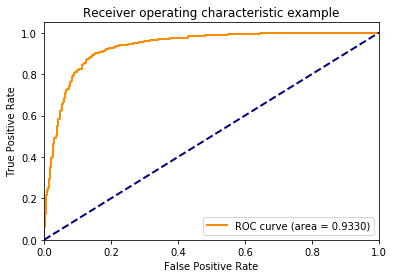

---------------------------------------------------------------------
Performance of pre-trained CNN model vgg16 for images at 40x:
              precision    recall  f1-score   support

      Benign       0.81      0.73      0.77       420
   Malignant       0.86      0.91      0.89       798

    accuracy                           0.85      1218
   macro avg       0.84      0.82      0.83      1218
weighted avg       0.84      0.85      0.84      1218

Image Level F1 Score: 0.8858
Patient Level Accuracy: 0.8594


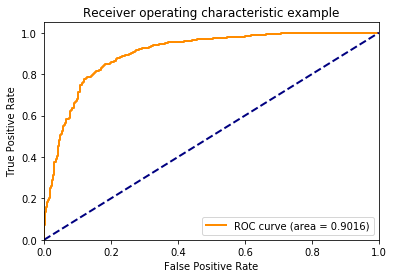

---------------------------------------------------------------------
Performance of pre-trained CNN model vgg19 for images at 40x:
              precision    recall  f1-score   support

      Benign       0.88      0.74      0.80       420
   Malignant       0.87      0.94      0.91       798

    accuracy                           0.87      1218
   macro avg       0.87      0.84      0.85      1218
weighted avg       0.87      0.87      0.87      1218

Image Level F1 Score: 0.9073
Patient Level Accuracy: 0.8741


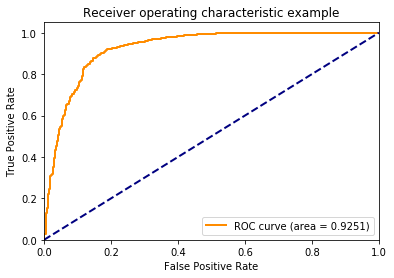

--------------------------------------------------------------------------------------------
Performance of pre-trained CNN model xception for images at 100x:
              precision    recall  f1-score   support

      Benign       0.80      0.70      0.75       444
   Malignant       0.86      0.91      0.89       894

    accuracy                           0.84      1338
   macro avg       0.83      0.81      0.82      1338
weighted avg       0.84      0.84      0.84      1338

Image Level F1 Score: 0.8867
Patient Level Accuracy: 0.8352


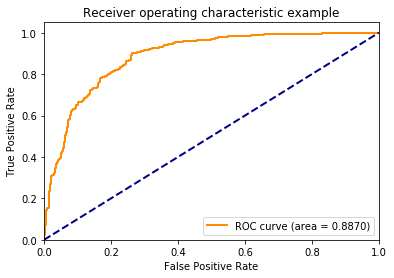

---------------------------------------------------------------------
Performance of pre-trained CNN model vgg16 for images at 100x:
              precision    recall  f1-score   support

      Benign       0.82      0.66      0.73       444
   Malignant       0.85      0.93      0.88       894

    accuracy                           0.84      1338
   macro avg       0.83      0.79      0.81      1338
weighted avg       0.84      0.84      0.83      1338

Image Level F1 Score: 0.8846
Patient Level Accuracy: 0.8283


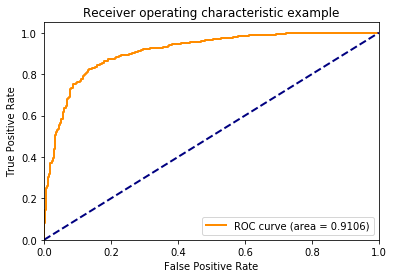

---------------------------------------------------------------------
Performance of pre-trained CNN model vgg19 for images at 100x:
              precision    recall  f1-score   support

      Benign       0.82      0.70      0.76       444
   Malignant       0.86      0.92      0.89       894

    accuracy                           0.85      1338
   macro avg       0.84      0.81      0.83      1338
weighted avg       0.85      0.85      0.85      1338

Image Level F1 Score: 0.8925
Patient Level Accuracy: 0.8451


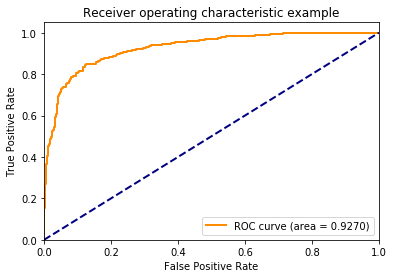

--------------------------------------------------------------------------------------------
Performance of pre-trained CNN model xception for images at 200x:
              precision    recall  f1-score   support

      Benign       0.82      0.73      0.77       441
   Malignant       0.87      0.92      0.89       876

    accuracy                           0.86      1317
   macro avg       0.85      0.83      0.83      1317
weighted avg       0.85      0.86      0.85      1317

Image Level F1 Score: 0.8949
Patient Level Accuracy: 0.8387


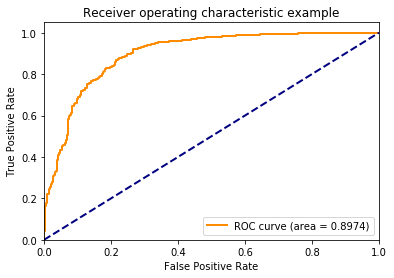

---------------------------------------------------------------------
Performance of pre-trained CNN model vgg16 for images at 200x:
              precision    recall  f1-score   support

      Benign       0.80      0.66      0.72       441
   Malignant       0.84      0.92      0.88       876

    accuracy                           0.83      1317
   macro avg       0.82      0.79      0.80      1317
weighted avg       0.83      0.83      0.83      1317

Image Level F1 Score: 0.8783
Patient Level Accuracy: 0.8107


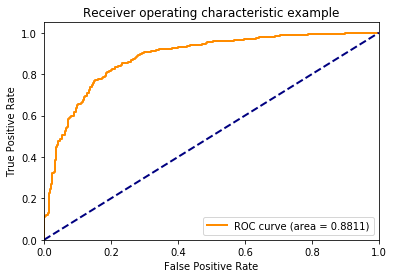

---------------------------------------------------------------------
Performance of pre-trained CNN model vgg19 for images at 200x:
              precision    recall  f1-score   support

      Benign       0.84      0.73      0.78       441
   Malignant       0.87      0.93      0.90       876

    accuracy                           0.86      1317
   macro avg       0.85      0.83      0.84      1317
weighted avg       0.86      0.86      0.86      1317

Image Level F1 Score: 0.8994
Patient Level Accuracy: 0.8430


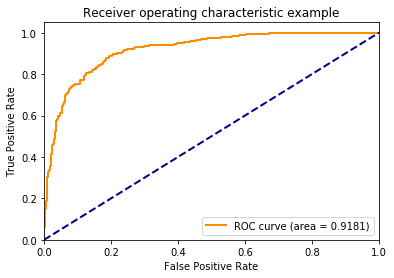

--------------------------------------------------------------------------------------------
Performance of pre-trained CNN model xception for images at 400x:
              precision    recall  f1-score   support

      Benign       0.72      0.67      0.69       390
   Malignant       0.84      0.87      0.85       774

    accuracy                           0.80      1164
   macro avg       0.78      0.77      0.77      1164
weighted avg       0.80      0.80      0.80      1164

Image Level F1 Score: 0.8531
Patient Level Accuracy: 0.8081


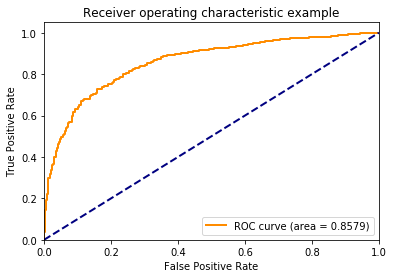

---------------------------------------------------------------------
Performance of pre-trained CNN model vgg16 for images at 400x:
              precision    recall  f1-score   support

      Benign       0.72      0.60      0.66       390
   Malignant       0.81      0.88      0.85       774

    accuracy                           0.79      1164
   macro avg       0.77      0.74      0.75      1164
weighted avg       0.78      0.79      0.78      1164

Image Level F1 Score: 0.8476
Patient Level Accuracy: 0.8007


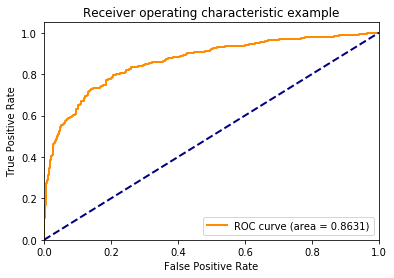

---------------------------------------------------------------------
Performance of pre-trained CNN model vgg19 for images at 400x:
              precision    recall  f1-score   support

      Benign       0.82      0.66      0.73       390
   Malignant       0.84      0.93      0.88       774

    accuracy                           0.84      1164
   macro avg       0.83      0.79      0.81      1164
weighted avg       0.84      0.84      0.83      1164

Image Level F1 Score: 0.8831
Patient Level Accuracy: 0.8387


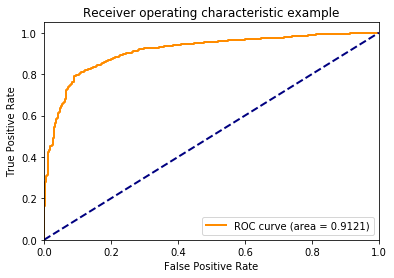

--------------------------------------------------------------------------------------------


In [0]:
# Classification performance of pre-trained models for images at each magnification level
for factor in magnification_factors:
  Model_Performance('xception', factor)
  print("---------------------------------------------------------------------")
  Model_Performance('vgg16', factor)
  print("---------------------------------------------------------------------")
  Model_Performance('vgg19', factor)
  print("--------------------------------------------------------------------------------------------")

## Appendix

In [0]:
# Different Candidate Classification Algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB

def defineClassifiers():
    """
    This function just defines each abbreviation used in the previous function (e.g. LR = Logistic Regression)
    """
    print('')
    print('LR = LogisticRegression')
    print('LDA = LinearDiscriminantAnalysis')
    print('DTC = DecisionTreeClassifier')
    print('RF = RandomForestClassifier')
    print('GBC = GradientBoostingClassifier')
    print('KNN = KNeighborsClassifier')
    print('SVM = Support Vector Machine SVC')
    print('LSVM = LinearSVC')
    print('GNB = GaussianNB')
    print('')
    return
defineClassifiers()

classifiers = {'LR': (LogisticRegression(), LR_parameters),
               'LDA': LinearDiscriminantAnalysis(),
               'DTC': DecisionTreeClassifier(),
               'RF': RandomForestClassifier(),
               'GBC': GradientBoostingClassifier(),
               'KNN': KNeighborsClassifier(),
               'SVM': (SVC(), SVM_parameters),
               'LSVM': LinearSVC(),
               'GNB': GaussianNB()}  

SVM_parameters = {'kernel':('linear', 'rbf'), 
                  'C':(1, 10)}

#LR_parameters = {'penalty': ('l1', 'l2'),
                 #'C' : (0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000),
                # 'class_weight' : ({1:0.5, 0:0.5}, {1:0.4, 0:0.6}, {1:0.6, 0:0.4}),
                # 'solver' : ('liblinear', 'saga')}

LR_parameters = {'solver' : ('liblinear', 'saga')}


# Tuning hyperparameter to get optimized classifier using GridSearchCV
def optimized_classifier(X_train, y_train, p_train, classifier_name):
    """Function that use logistic regression as classifier and return Cross-validated F1 Score"""
    # Hyperparameter Tuning using group k folds cross validation
    group_kfold = GroupKFold(n_splits=3)
    parameters = classifiers[classifier_name][1]
    model = classifiers[classifier_name][0]
    grid = GridSearchCV(estimator=model, 
                       param_grid=parameters,
                       cv=group_kfold,
                       scoring=['roc_auc','f1'],
                       verbose=1,
                       n_jobs=-1,
                       refit='f1')
    grid_result = grid.fit(X_train, y_train, p_train) 
    # summarize results
    print("Best F1 score: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_f1']
    stds = grid_result.cv_results_['std_test_f1']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    return grid_result.best_estimator_

# Test the Function
X = np.load('/gdrive/My Drive/Colab Notebooks/Medical informatics/Project/data/features/xception/40/X.npy')
X_Shape = X.shape[1]*X.shape[2]*X.shape[3]*X.shape[4]
X_Flat = X.reshape(X.shape[0], X_Shape)
y = np.load('/gdrive/My Drive/Colab Notebooks/Medical informatics/Project/data/for feature_extraction/xception/40/y.npy')
p = np.load('/gdrive/My Drive/Colab Notebooks/Medical informatics/Project/data/for feature_extraction/xception/40/p.npy')
optimized_classifier(X_Flat, y, p, 'LR' )